In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  os # data 

# Image processing
from PIL import Image, ImageFile
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Plotting
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
path, dirs, files = next(os.walk("./boats"))
dirs

['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

In [3]:
boat_types = ['cruise ship', 'gondola', 'kayak', 'sailboat', 'ferry boat', 'buoy', 'freight boat', 'inflatable boat', 'paper boat',] 

In [4]:
import glob

i = 0

X_data = []
Y_data = []

for boat in boat_types:
    print(boat)
    files = glob.glob ("./boats/" + str(boat) + "/*.jpg")
    
    for myFile in files:
      img = Image.open(myFile)
      #img.thumbnail((width, height), Image.ANTIALIAS) # resizes image in-place keeps ratio
      img = img.resize((200,200), Image.ANTIALIAS) # resizes image without ratio
      img = np.array(img)

      if img.shape == (200, 200, 3):
        # Add the numpy image to matrix with all data
        X_data.append (img)
        Y_data.append (i)
      else:
        print(myFile)
        
    i += 1
print("Converting the lists to numpy arrays and make the output categorical")

cruise ship
gondola
kayak
sailboat
ferry boat
buoy
freight boat
inflatable boat
paper boat
Converting the lists to numpy arrays and make the output categorical


In [5]:
X = np.array(X_data)
Y = np.array(Y_data)
# Print shapes to see if they are correct
print(X.shape)
print(Y.shape)

(1585, 200, 200, 3)
(1585,)


In [6]:
from keras.utils.np_utils import to_categorical
X = X.astype('float32') / 255.0
y_cat = to_categorical(Y_data, len(boat_types))

In [7]:
boats = []
number_of_boats = []

path, dirs, files = next(os.walk("./boats"))  

for dir in dirs:
  path2, dirs2, files2 = next(os.walk("./boats/" + dir))  
  boats.append(dir)
  number_of_boats.append(len(files2))

 
df = pd.DataFrame({'Boat Types':boats, 'N':number_of_boats})
df = df.sort_values(['N'], ascending=False)

df_actual = df.set_index('Boat Types')
df_actual = df_actual.loc[boat_types]
df_actual = df_actual.sort_values(['N'], ascending=False)

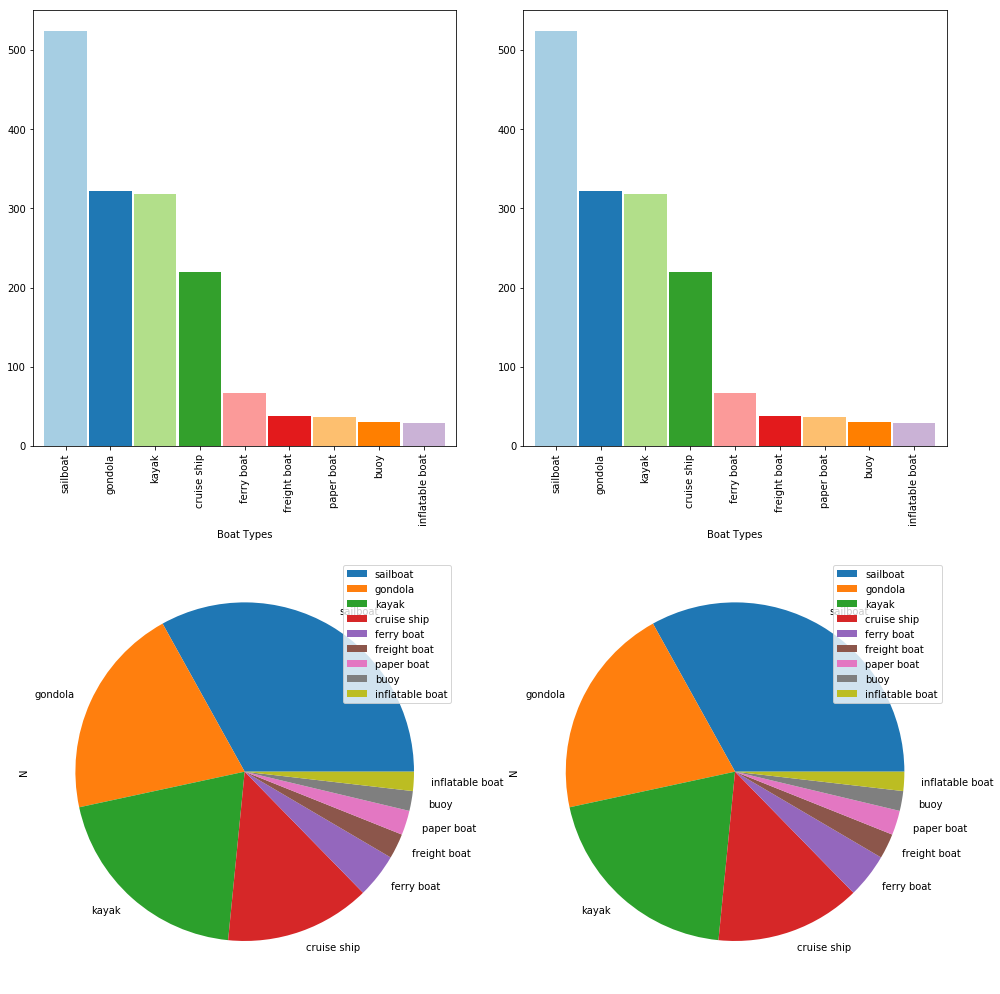

In [8]:
fig, axes = plt.subplots(2,2, figsize=(14,14))  # 1 row, 2 columns
df.plot('Boat Types', ax=axes[0,0], kind='bar', legend=False, color=[plt.cm.Paired(np.arange(len(df)))], width=0.95)
df_actual.plot(kind='bar', ax=axes[0,1], legend=False, color=[plt.cm.Paired(np.arange(len(df)))], width=0.95)
df.plot('Boat Types', 'N', kind='pie', labels=df['Boat Types'], ax=axes[1,0])
df_actual.plot('N', kind='pie', ax=axes[1,1], subplots=True)
plt.tight_layout()

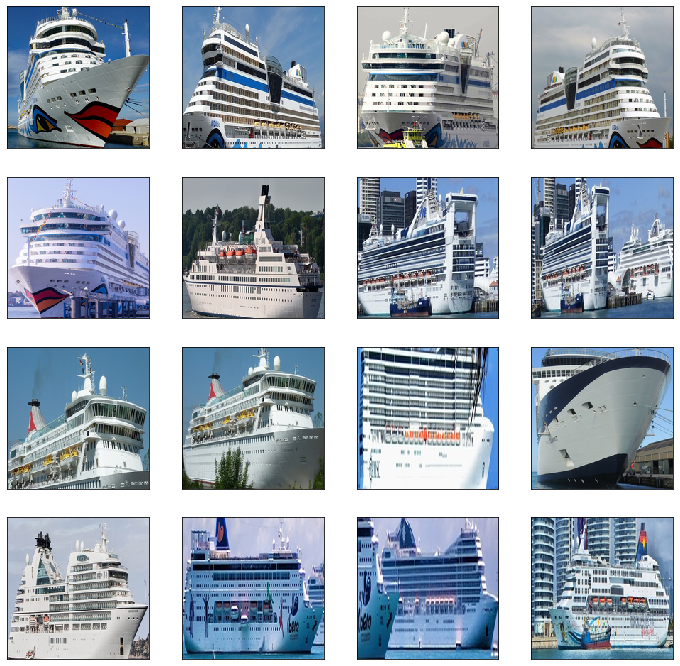

In [9]:
plt.close('all')
plt.figure(figsize=(12, 12))

for i in range(16):
  # Plot the images in a 4x4 grid
  plt.subplot(4, 4, i+1)

  # Plot image [i]
  plt.imshow(X[i])
  
  # Turn off axis lines
  cur_axes = plt.gca()
  cur_axes.axes.get_xaxis().set_visible(False)
  cur_axes.axes.get_yaxis().set_visible(False)

In [10]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

In [11]:
import keras.backend as K
def load_CNN(output_size):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(128, (5, 5),
               input_shape=(200, 200, 3),
               activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(output_size, activation='softmax'))
  return model

In [12]:
early_stop_loss = EarlyStopping(monitor='loss', patience=3, verbose=1)
early_stop_val_acc = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
model_callbacks=[early_stop_loss, early_stop_val_acc]

In [13]:
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.layers import Activation, Dense
from keras.utils.np_utils import to_categorical

from keras.optimizers import SGD, Adam, Adagrad, RMSprop

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)
print("The model has " + str(len(X_train)) + " inputs")

The model has 1109 inputs


In [15]:
model = load_CNN(len(boat_types))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 196, 196, 128)     9728      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
__________

In [17]:
print("compiling~")
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

weights = model.get_weights()

compiling~


In [18]:
learning_rates = [0.0005] #0.01, 0.005, 0.001, 0.0005, 0.0001
# lrsHistories_acc = []
# lrsHistories_val = []
for lr in learning_rates:
    print(lr)
    model=load_CNN(len(boat_types))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr),
                  metrics=['accuracy'])
    h = model.fit(X_train, y_train, 
                  batch_size=32, 
                  epochs=25, 
                  verbose=1, 
                  callbacks=[early_stop_loss],
                  shuffle=True,
                  validation_data=(X_test, y_test))

#     lrsHistories_acc.append(h.history['acc'])
#     lrsHistories_val.append(h.history['val_acc'])
# lrsHistories_acc = np.array(lrsHistories_acc)
# lrsHistories_val = np.array(lrsHistories_val)

0.0005
Train on 1109 samples, validate on 476 samples
Epoch 1/25
1109/1109 [==============================] - 234s 211ms/step - loss: 0.2958 - acc: 0.8901 - val_loss: 0.2900 - val_acc: 0.8896
Epoch 2/25
1109/1109 [==============================] - 212s 191ms/step - loss: 0.2511 - acc: 0.9030 - val_loss: 0.2488 - val_acc: 0.9057
Epoch 3/25
1109/1109 [==============================] - 198s 178ms/step - loss: 0.2074 - acc: 0.9229 - val_loss: 0.2184 - val_acc: 0.9183
Epoch 4/25
1109/1109 [==============================] - 201s 181ms/step - loss: 0.1822 - acc: 0.9286 - val_loss: 0.2010 - val_acc: 0.9260
Epoch 5/25
1109/1109 [==============================] - 196s 177ms/step - loss: 0.1486 - acc: 0.9431 - val_loss: 0.2202 - val_acc: 0.9202
Epoch 6/25
1109/1109 [==============================] - 197s 177ms/step - loss: 0.1081 - acc: 0.9592 - val_loss: 0.2411 - val_acc: 0.9204
Epoch 7/25
1109/1109 [==============================] - 196s 177ms/step - loss: 0.0776 - acc: 0.9728 - val_loss: 0.262

In [19]:
# optimizers = ['SGD(lr=0.0001)',
#               'SGD(lr=0.0001, momentum=0.3)',
#               'SGD(lr=0.0001, momentum=0.3, nesterov=True)',  
#               'Adam(lr=0.0001)',
#               'Adagrad(lr=0.0001)',
#               'RMSprop(lr=0.0001)']

# optimizeList_acc = []
# optimizeList_val = []

# # for opt_name in optimizers:
# opt_name = optimizers[3]
# print("heyyyyy")
# model=load_CNN(2)

# model.compile(loss='binary_crossentropy',
#               optimizer=eval(opt_name),
#               metrics=['accuracy'])
# h = model.fit(X_train, y_train, 
#               batch_size=16, 
#               epochs=25, 
#               verbose=0, 
#               callbacks=[early_stop_loss],
#               shuffle=True,
#               validation_data=(X_test, y_test))

# optimizeList_acc.append(h.history['acc'])
# optimizeList_val.append(h.history['val_acc'])
    
# optimizeList_acc = np.array(optimizeList_acc)
# optimizeList_val = np.array(optimizeList_val)

In [24]:
import random
image_number = random.randint(0,len(X_train))
print(image_number)

733


In [25]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[image_number].reshape(1,200,200,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(12,12))
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)    
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

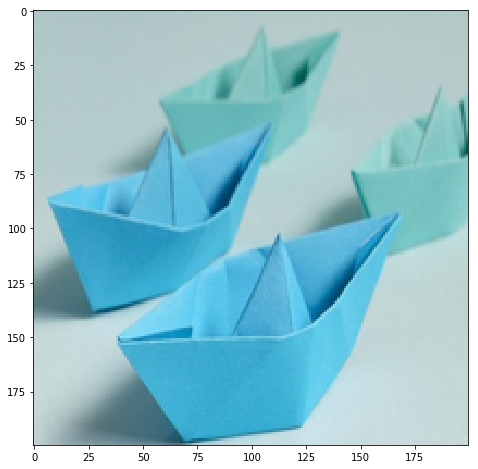

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(X_train[image_number])

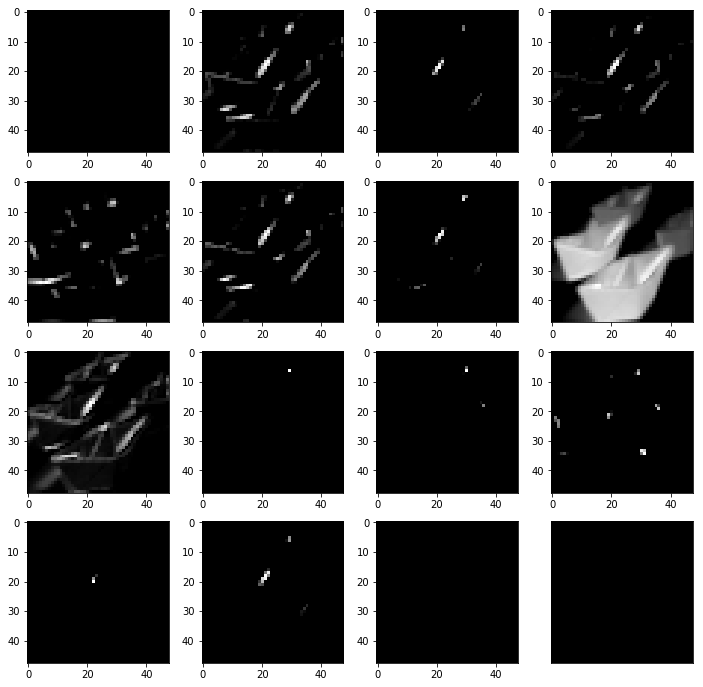

In [27]:
display_activation(activations, 4, 4, 4)

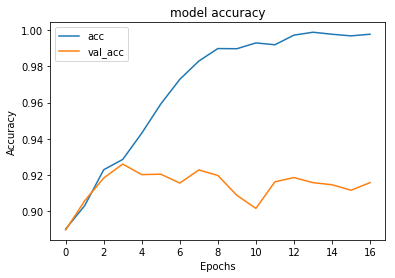

In [28]:
plt.title('model accuracy')
plt.plot(h.history['acc'], label='accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['acc',
            'val_acc'], loc='best')

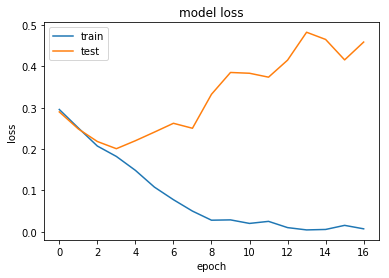

In [29]:
# summarize history for loss

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()